## Using pynoddy to generate features in geological model space

In [1]:
from IPython.core.display import HTML
css_file = 'pynoddy.css'
HTML(open(css_file, "r").read())

In [2]:
import sys, os
import matplotlib.pyplot as plt
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
import pynoddy.history

In [3]:
%matplotlib inline

In [57]:
reload(pynoddy.history)
reload(pynoddy.events)
reload(pynoddy)
history = "feature_model.his"
output_name = "feature_out"
nm = pynoddy.history.NoddyHistory()
# add stratigraphy
strati_options = {'num_layers' : 8,
                  'layer_names' : ['layer 1', 'layer 2', 'layer 3',
                                   'layer 4', 'layer 5', 'layer 6', 
                                   'layer 7', 'layer 8'],
                  'layer_thickness' : [1500, 500, 500, 500, 500, 
                                       500, 500, 500]}
nm.add_event('stratigraphy', strati_options )

fold_options = {'name' : 'Fold',
                 'pos' : (4000, 3500, 5000),
                 'amplitude' : 200,
                'dip_dir' : 135.0,
                 'wavelength' : 5000}

nm.add_event('fold', fold_options)

# The following options define the fault geometry:
fault_options = {'name' : 'Fault_W',
                 'pos' : (4000, 3500, 5000),
                 'dip_dir' : 90,
                 'dip' : 60,
                 'slip' : 1000}

nm.add_event('fault', fault_options)
# The following options define the fault geometry:
fault_options = {'name' : 'Fault_E',
                 'pos' : (6000, 3500, 5000),
                 'dip_dir' : 270,
                 'dip' : 60,
                 'slip' : 1000}

nm.add_event('fault', fault_options)
nm.write_history(history)

In [58]:
# Change cube size
nm1 = pynoddy.history.NoddyHistory(history)
nm1.change_cube_size(50)
nm1.write_history(history)

In [59]:
# Compute the model
pynoddy.compute_model(history, output_name) 

''

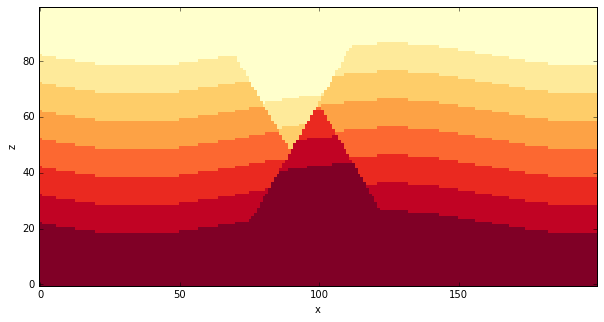

In [60]:
# Plot output
import pynoddy.output
reload(pynoddy.output)
nout = pynoddy.output.NoddyOutput(output_name)
nout.plot_section('y', layer_labels = strati_options['layer_names'][::-1], 
                  colorbar = True, title="",
                  savefig = False, fig_filename = "ex01_faults_combined.eps",
                  cmap = 'YlOrRd') # note: YlOrRd colourmap should be suitable for colorblindness!

In [10]:
import os
history_file = os.path.join(repo_path, "examples/GBasin_Ve1_V4.his")

In [11]:
his_gipps = pynoddy.history.NoddyHistory(history_file)

In [14]:
his_gipps.events[2].properties

{'Amplitude': 500.0,
 'Cylindricity': 0.0,
 'Dip': 90.0,
 'Dip Direction': 90.0,
 'Pitch': 0.0,
 'Single Fold': 'FALSE',
 'Type': 'Sine',
 'Wavelength': 15000.0,
 'X': 0.0,
 'Y': 0.0,
 'Z': 0.0}